In [1]:
import os
import torch
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from roboflow import Roboflow
import matplotlib.pyplot as plt
import warnings
import json
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
# Configuration
CONFIG = {
    "api_key": "DEox6oznQeGVSq8h49uK",
    "workspace": "school-ny3mt",
    "project": "hepsi-humo1",
    "version": 2,
    "data_dir": "./hepsi-2",
    "num_classes": 15,
    "batch_size": 10,
    "num_epochs": 10,
    "learning_rate": 0.01,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "model_save_path": "cnn_model.pth",
    "epsilon": 0.1,  # For FGSM attack
    "is_train": True  # True for training, False for loading the trained model
}

In [3]:
# download open source dataset
rf = Roboflow(api_key=CONFIG["api_key"])
project = rf.workspace("school-ny3mt").project("hepsi-humo1") 
dataset = project.version(2).download("coco") 

loading Roboflow workspace...
loading Roboflow project...


In [4]:
class RoboDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for Roboflow COCO formatted data.
    
    Args:
        root (str): Path to the image directory
        annotation (str): Path to the COCO annotation file
        transforms (callable, optional): Optional transforms to be applied
    """
    
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        """
        Loads and returns a sample from the dataset at the given index.
        
        Args:
            index (int): Index
            
        Returns:
            tuple: (image, target) where target is a dictionary containing:
                - boxes (FloatTensor[N, 4]): the ground-truth boxes in [xmin, ymin, xmax, ymax] format
                - labels (Int64Tensor[N]): the class label for each ground-truth box
                - image_id (Int64Tensor[1]): an identifier for the image
                - area (Tensor[N]): The area of the bounding box
                - iscrowd (UInt8Tensor[N]): iscrowd flag
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        # Convert COCO bbox format [xmin, ymin, width, height] to PyTorch format [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin, ymin, width, height = coco_annotation[i]['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([ann['category_id'] for ann in coco_annotation], dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = torch.as_tensor([ann['area'] for ann in coco_annotation], dtype=torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": img_id,
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [5]:

def get_transform():
    """Basic transform to convert PIL Image to Tensor"""
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

def get_model_instance_segmentation(num_classes):
    """
    Initialize a Faster R-CNN model with a custom head for the given number of classes.
    
    Args:
        num_classes (int): Number of output classes
        
    Returns:
        model (torch.nn.Module): Initialized Faster R-CNN model
    """
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    
    # Replace the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

def fast_gradient_sign_method(model, images, targets, epsilon=0.15):
    """
    Fast Gradient Sign Method (FGSM) attack for object detection models.
    
    Args:
        model (torch.nn.Module): The model to attack
        images (Tensor): Input images
        targets (list[dict]): Target annotations
        epsilon (float): Attack strength
        
    Returns:
        tuple: (adversarial_images, noise)
    """
    # Set model to training mode to enable gradient computation
    model.train()
    
    # Clone images and enable gradient tracking
    perturbed_images = images.clone().requires_grad_()
    
    # Forward pass
    loss_dict = model(perturbed_images, targets)
    losses = sum(loss for loss in loss_dict.values())
    
    # Backward pass to compute gradients
    model.zero_grad()
    losses.backward()
    
    # Create adversarial examples
    noise = torch.sign(perturbed_images.grad.data)
    adversarial_images = images + epsilon * noise
    adversarial_images = torch.clamp(adversarial_images, 0, 1)  # Maintain valid pixel range
    
    # Set model back to eval mode
    model.eval()
    
    return adversarial_images.detach(), noise.detach()

def train_model(model, data_loader, device, num_epochs=10):
    """Training loop for the object detection model"""
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, 
        lr=CONFIG['learning_rate'],
        momentum=CONFIG['momentum'],
        weight_decay=CONFIG['weight_decay']
    )
    
    model.train()
    for epoch in range(num_epochs):
        for i, (images, targets) in enumerate(data_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Skip empty targets
            if targets[0]['boxes'].size()[0] == 0:
                continue
                
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            print(f'Epoch: {epoch}, Iteration: {i}/{len(data_loader)}, Loss: {losses.item()}')

In [9]:
# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create datasets and data loaders
train_dataset = RoboDataset(
    root=os.path.join(CONFIG['data_dir'], 'train'),
    annotation=os.path.join(CONFIG['data_dir'], 'train/_annotations.coco.json'),
    transforms=get_transform()
)

test_dataset = RoboDataset(
root=os.path.join(CONFIG['data_dir'], 'test'),
annotation=os.path.join(CONFIG['data_dir'], 'test/_annotations.coco.json'),
    transforms=get_transform()
)

def collate_fn(batch):
    return tuple(zip(*batch))

def data_loader_fn(dataset, batch_size=1, shuffle=False, num_workers=0, index_id = None):
    return torch.utils.data.DataLoader(
        torch.utils.data.Subset(dataset, [index_id]),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Initialize model
model = get_model_instance_segmentation(CONFIG['num_classes'])
model.to(device)

Using device: cuda
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [10]:
# Train or load model
if CONFIG["is_train"]:
    print("Training model...")
    train_model(model, train_loader, device, CONFIG['num_epochs'])
    torch.save(model.state_dict(), CONFIG['model_save_path'])
else:
    print("Loading pretrained model...")
    model.load_state_dict(torch.load(CONFIG['model_save_path']))

model.eval()

Training model...
Epoch: 0, Iteration: 0/1974, Loss: 3.5148391723632812
Epoch: 0, Iteration: 1/1974, Loss: 2.969961404800415
Epoch: 0, Iteration: 2/1974, Loss: 1.8954530954360962
Epoch: 0, Iteration: 3/1974, Loss: 0.9724260568618774
Epoch: 0, Iteration: 4/1974, Loss: 0.727791965007782
Epoch: 0, Iteration: 5/1974, Loss: 1.697074294090271
Epoch: 0, Iteration: 6/1974, Loss: 0.31280091404914856
Epoch: 0, Iteration: 7/1974, Loss: 0.2877576947212219
Epoch: 0, Iteration: 8/1974, Loss: 0.23246902227401733
Epoch: 0, Iteration: 9/1974, Loss: 0.1535653918981552
Epoch: 0, Iteration: 10/1974, Loss: 0.2993529736995697
Epoch: 0, Iteration: 11/1974, Loss: 1.7263928651809692
Epoch: 0, Iteration: 12/1974, Loss: 0.2877240478992462
Epoch: 0, Iteration: 13/1974, Loss: 0.20674538612365723
Epoch: 0, Iteration: 14/1974, Loss: 0.1612596958875656
Epoch: 0, Iteration: 15/1974, Loss: 0.18257735669612885
Epoch: 0, Iteration: 16/1974, Loss: 0.08755987882614136
Epoch: 0, Iteration: 17/1974, Loss: 0.11840999126434326

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

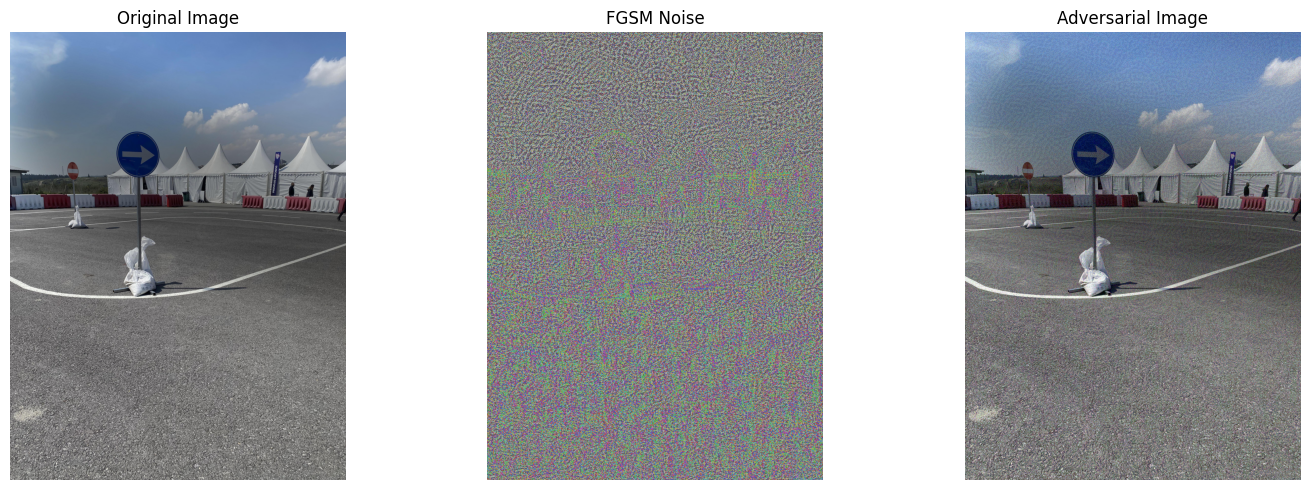

In [14]:
# load test dataset
test_images, test_targets = next(iter(data_loader_fn(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, index_id=25)))
test_images = list(img.to(device) for img in test_images)
test_targets = [{k: v.to(device) for k, v in t.items()} for t in test_targets]


# Generate adversarial example
adv_images, noise = fast_gradient_sign_method(
    model,
    test_images[0].unsqueeze(0),
    test_targets,
    epsilon=CONFIG['epsilon']
)

# Visualize results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(test_images[0].cpu().numpy().transpose(1, 2, 0))
plt.title("Original Image")
plt.axis('off')

# Noise
noise_rescaled = (noise[0].cpu().numpy().transpose(1, 2, 0) + 1.0) / 2.0 
plt.subplot(1, 3, 2) 
plt.imshow(noise_rescaled)
plt.title("FGSM Noise")
plt.axis('off')

# Adversarial image
plt.subplot(1, 3, 3)
plt.imshow(adv_images[0].cpu().numpy().transpose(1, 2, 0))
plt.title("Adversarial Image")
plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# prediction output
with open("./hepsi-2/test/_annotations.coco.json", "r") as f:
    labels = json.load(f)

print("\nOriginal image predictions:")
orig_preds = model(test_images[0].unsqueeze(0))
print(f" Prediction label {orig_preds[0]['labels'][0]}: {labels['categories'][orig_preds[0]['labels'][0]]['name']}")
    
print("\nAdversarial image predictions:")
adv_preds = model(adv_images[0].unsqueeze(0))
print(f" Prediction label {adv_preds[0]['labels'][0]}: {labels['categories'][adv_preds[0]['labels'][0]]['name']}")



Original image predictions:
 Prediction label 7: mandatory_right

Adversarial image predictions:
 Prediction label 10: no_park
